In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

## Données de Température

### Présentation du jeu de données

Dans cette section, nous présentons les données utilisées pour notre analyse de la température. Les données sont initialement dispersées sur un grand nombre de fichiers, un pour chaque département. Ces fichiers contiennent des informations sur la température moyenne mensuelle, mais les données sont incohérentes et nécessitent un nettoyage avant de pouvoir être utilisées efficacement dans nos analyses.



In [2]:
def process_climat_data(df_climat):
    df_commune_1 = pd.read_csv('POSTES_MF.csv', delimiter=';', encoding='utf-8')
    df_commune_2 = pd.read_csv('POSTES-COMP.csv', delimiter=';', encoding='utf-8')
    df_commune = pd.concat([df_commune_1, df_commune_2], ignore_index=True)
    df_commune.drop_duplicates(subset='NOM_USUEL', inplace=True)

    df_climat_merge = pd.merge(df_climat, df_commune[['NOM_USUEL', 'COMMUNE']], on='NOM_USUEL', how='left')
    colonnes_utiles = ['COMMUNE', 'AAAAMM', 'TMM', 'TX', 'TN']
    df_clean = df_climat_merge[colonnes_utiles].copy()
    df_clean.dropna(inplace=True)

    df_clean['Date'] = pd.to_datetime(df_clean['AAAAMM'], format='%Y%m')

    def get_season(month):
        if month in [12, 1, 2]: return 'Hiver'
        elif month in [3, 4, 5]: return 'Printemps'
        elif month in [6, 7, 8]: return 'Été'
        else: return 'Automne'

    df_clean['Saison'] = df_clean['Date'].dt.month.map(get_season)
    df_clean.drop(columns='AAAAMM', inplace=True)

    df_clean.rename(columns={
        'COMMUNE': 'Commune',
        'TMM': 'Température moyenne mensuelle',
        'TX': 'Température maximale',
        'TN': 'Température minimale'
    }, inplace=True)

    df_clean['Année'] = df_clean['Date'].dt.year

    annual_avg_temp = df_clean.groupby(['Commune', 'Année'])['Température moyenne mensuelle'].mean().reset_index()
    annual_avg_temp.rename(columns={'Température moyenne mensuelle': 'Température moyenne annuelle'}, inplace=True)

    centiles = df_clean.groupby(['Commune', 'Année'])['Température moyenne mensuelle'].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
    centiles.rename(columns={0.25: 'Centile_25%', 0.5: 'Centile_50% (Médiane)', 0.75: 'Centile_75%'}, inplace=True)

    df_clean = pd.merge(df_clean, annual_avg_temp, on=['Commune', 'Année'], how='left')
    df_clean = pd.merge(df_clean, centiles, on=['Commune', 'Année'], how='left')

    return df_clean

In [3]:
# Directory containing the climat files
climat_directory = 'climat_files'
new_climat_directory = 'climat_files_processed'

files = [f for f in os.listdir(climat_directory)]

# Loop over each file and process it
for file in files:

    file_path = os.path.join(climat_directory, file)

    df_climat = pd.read_csv(file_path, delimiter=';', encoding='utf-8')
    
    processed_data = process_climat_data(df_climat)
    
    output_file = os.path.join(new_climat_directory, f"processed_{file}")
    
    processed_data.to_csv(output_file, index=False)
    
    print(f"Processed file saved as: {output_file}")


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'climat_files'

In [ ]:
merged_df = []


def extract_department_from_filename(filename):
    match = re.search(r'processed_MENSQ_(\d{2})_', filename)
    return match.group(1) if match else None

# Loop over all processed files
for file in os.listdir(new_climat_directory):
    if file.endswith(".csv") and file.startswith("processed_MENSQ_"):
        file_path = os.path.join(new_climat_directory, file)
        df = pd.read_csv(file_path)

        # Extract department and add it as a column
        dept = extract_department_from_filename(file)
        df['Département'] = dept

        merged_df.append(df)

# Concatenate all DataFrames
final_df = pd.concat(merged_df, ignore_index=True)
final_df = final_df[final_df['Année'] >= 2018]
# Save the merged result
final_df.to_csv('climat_merged_all_departments.csv', index=False)
print("Merged file saved as: climat_merged_all_departments.csv")


## Visualisations de la Température en fonction de la Consommation Électrique
### 1. Histogramme de la Consommation Énergétique en Fonction des Intervalles de Température


In [2]:
df_all = pd.read_csv('data-final-02_04.csv')

/var/folders/__/d39q8d5n2k71j82c7ngscbp40000gn/T/ipykernel_4935/921999712.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_consumption = df_all.groupby('Temp_binned')['Consommation annuelle moyenne par logement de l\'adresse (MWh)'].mean()


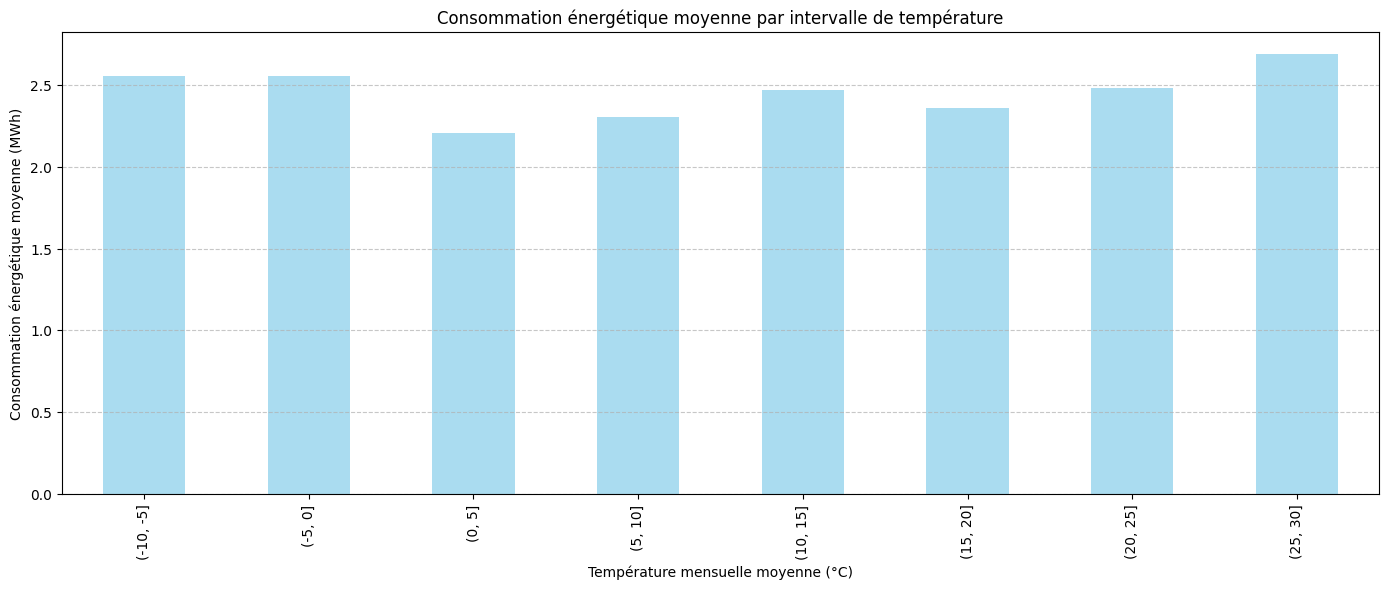

In [4]:
# Grouping temperature into bins and calculating average consumption per bin
bins = [-10, -5 , 0, 5, 10, 15, 20, 25, 30]  # Définir les intervalles de température

df_all['Temp_binned'] = pd.cut(df_all['Température moyenne mensuelle'], bins)

# Calculer la consommation d'énergie moyenne par intervalle de température
avg_consumption = df_all.groupby('Temp_binned')['Consommation annuelle moyenne par logement de l\'adresse (MWh)'].mean()

# Afficher l'histogramme
plt.figure(figsize=(17,6))
avg_consumption.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title("Consommation énergétique moyenne par intervalle de température")
plt.xlabel("Température mensuelle moyenne (°C)")
plt.ylabel("Consommation énergétique moyenne (MWh)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

L'histogramme montre la **consommation énergétique moyenne** par logement en fonction des **intervalles de température mensuelle moyenne**.

- La consommation énergétique reste relativement constante dans les intervalles de température allant de **-10 à 0°C** et **0 à 5°C**. Cela peut indiquer que dans ces températures plus froides, les logements consomment davantage pour le chauffage, mais les valeurs restent similaires.

- Dans les intervalles entre **5 à 10°C** et **10 à 15°C**, la consommation énergétique reste stable, avec des valeurs légèrement plus élevées que dans les intervalles plus froids. Cela pourrait suggérer que les températures modérées nécessitent encore un certain chauffage ou un apport d'énergie.

- Les températures plus élevées (de **15 à 20°C**, **20 à 25°C** et **25 à 30°C**) montrent également une consommation énergétique similaire, ce qui peut être expliqué par l'utilisation accrue de la climatisation ou d'autres appareils énergétiques pour maintenir une température confortable.

Le graphique montre que la consommation énergétique moyenne par logement est relativement homogène à travers différents intervalles de température, bien qu'une légère tendance à la hausse soit visible dans les températures plus chaudes.


### 2. Heatmap de la Corrélation entre Température et Consommation d'Énergie

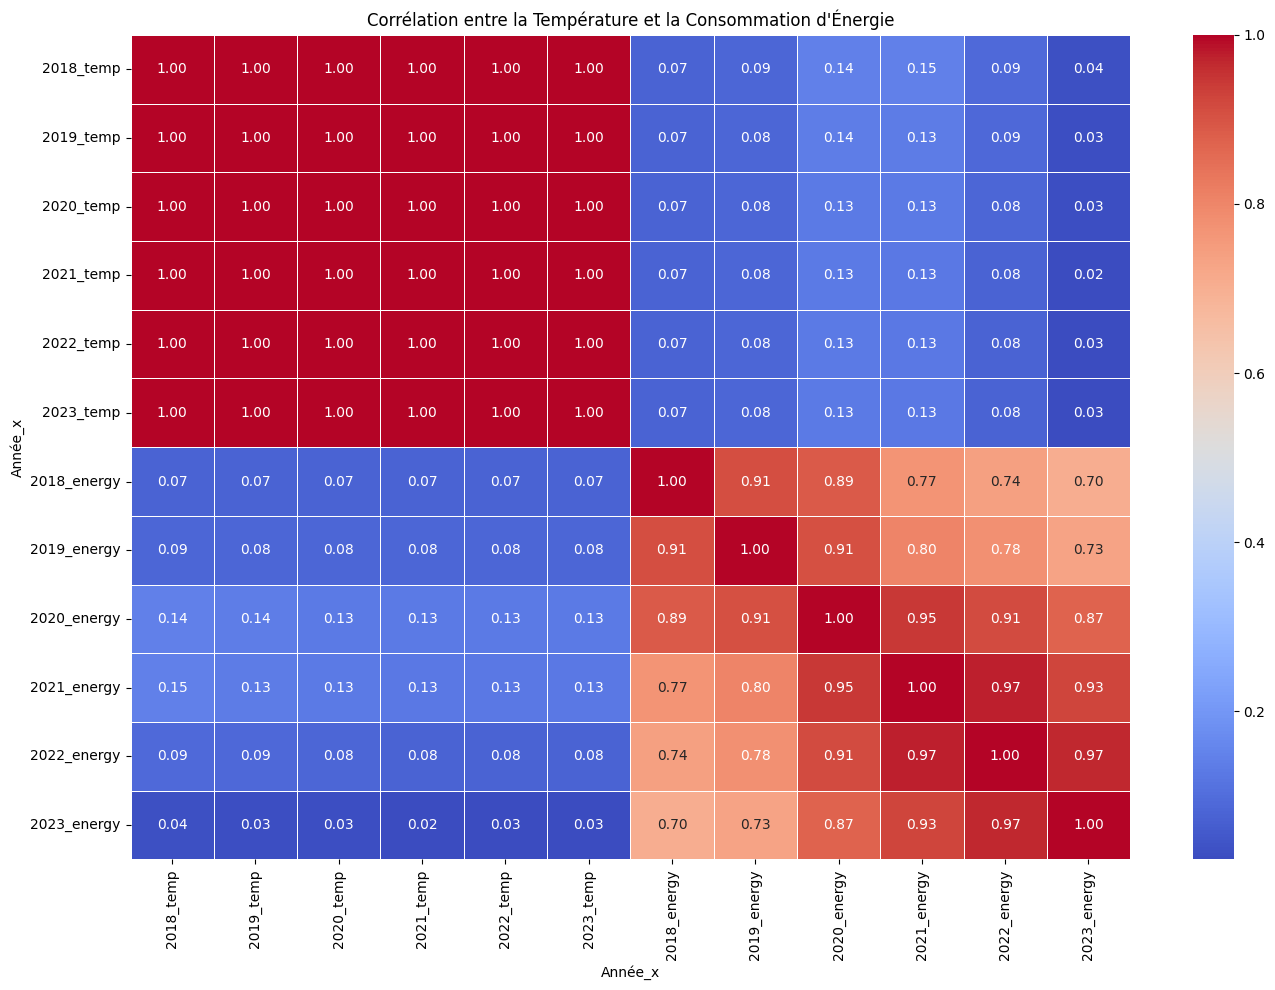

In [5]:
heatmap_data = df_all.pivot_table(index='Nom Commune', columns='Année_x', values='Température moyenne mensuelle')
#change y
heatmap_energy = df_all.pivot_table(index='Nom Commune', columns='Année_x', values='Consommation annuelle moyenne par logement de l\'adresse (MWh)')

# Combine temperature and energy consumption data
combined_data = heatmap_data.join(heatmap_energy, lsuffix='_temp', rsuffix='_energy')

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(combined_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Corrélation entre la Température et la Consommation d\'Énergie')
plt.tight_layout()
plt.show()

Le **heatmap** ci-dessus montre la **corrélation** entre la **température moyenne mensuelle** et la **consommation énergétique annuelle moyenne par logement** pour chaque année permettant de comprendre si la température a un impact significatif sur la consommation d'énergie.. Les couleurs du graphique indiquent la force de la corrélation entre ces deux variables.

- **Corrélations entre les années** :
  - La diagonale du graphique montre que les températures de chaque année sont parfaitement corrélées avec elles-mêmes (valeur de 1.00), ce qui est attendu.
  - Les corrélations entre les **températures** et les **consommations d'énergie** sont généralement faibles. Par exemple, pour **2023**, la corrélation entre la température et la consommation d'énergie est de **0.04**, ce qui indique une très faible relation.
  - La **corrélation la plus forte** se trouve en **2021** (avec une valeur de **0.15**), ce qui suggère une relation faible mais légèrement plus significative cette année-là. Cela peut signifier que la température en 2021 a eu un léger impact sur la consommation énergétique.
  - Pour les autres années (2018 à 2023), les corrélations entre la température et la consommation d'énergie varient, mais restent relativement faibles (toutes inférieures à **0.2**).

Pour conclure, le graphique montre que **la température a une influence limitée** sur la consommation d'énergie. Bien qu'il existe des corrélations faibles, elles ne sont pas suffisamment fortes pour suggérer que la température soit le facteur principal influençant la consommation d'énergie. Cela confirme l'hypothèse qu'il existe probablement **d'autres facteurs** qui influencent davantage la consommation énergétique. 